Lets try to extend Hogg's 1D trivial analogous to a 2D one where we can test how well ICA does

In [190]:
import numpy as np 
from scipy.stats import gaussian_kde as gkde
from sklearn.decomposition import FastICA, PCA
# -- local --
import env
import util as UT
import hogg as Hogg
# -- plotting -- 
from corner import corner
import matplotlib.pyplot as plt 
from ChangTools.plotting import prettyplot
from ChangTools.plotting import prettycolors
%matplotlib inline

We draw data from a 2D Gaussian with True 
$\mu = 
\begin{bmatrix}
7 \\ 
5 
\end{bmatrix}$ and True covariance
${\bf V} = 
\begin{bmatrix}
17 & 0 \\
0 & 20 
\end{bmatrix}$

In [122]:
Truth = np.array([7., 5., 17., 0., 0., 20.])
N = 5

In [123]:
def datadraw(stats, N): 
    cov = np.array([stats[2:4], stats[4:6]])
    return np.random.multivariate_normal(stats[0:2], cov, size=N)

In [124]:
np.random.seed(7)
data = datadraw(Truth, N)

In [125]:
print data.shape
print data

(5, 2)
[[  5.07889101  12.56026078]
 [  8.68023268   5.14677623]
 [  7.00851658   1.47182896]
 [ -0.23491366   4.99601807]
 [  9.47591881   9.55110496]]


In [126]:
mu_emp = np.array([np.mean(data[:,0]), np.mean(data[:,1])])
cov_emp = np.cov(data.T)
print 'empirical mu = ', mu_emp
print 'empirical covariance '
print cov_emp

empirical mu =  [ 6.00172908  6.7451978 ]
empirical covariance 
[[ 15.00133491   1.42509041]
 [  1.42509041  18.77776816]]


The correct likelihood for $\{ {\bf y}_n\}$ can be written as
$$ ln \; p(\{ {\bf y}_n\}|\mu, {\bf V}) = -\frac{1}{2} \sum_{n=1}^{N} ({\bf y}_n - \mu)^T {\bf V}^{-1} ({\bf y}_n - \mu)- \frac{N}{2} ln \,det({\bf V})$$
Lets run a MCMC using this correct likelihood with uniform prior $0 < \mu_i < 10$, $0 < V_{i,i} < 100$, $0 < V_{i,j} < 10$. 

In [132]:
def ln_correct_likelihood(data, pars):
    mean = pars[0:2]
    cov = np.array([pars[2:4], pars[4:6]])
    res = (data - mean)
    
    lnL = 0. 
    for i in range(len(res)): 
        lnL += - 0.5 * np.sum(np.dot(res[i,:], np.linalg.solve(cov, res[i,:].T)))
    if np.linalg.det(cov) > 0: 
        return lnL - 0.5 * len(data) * np.log(np.linalg.det(cov))
    else: 
        return -np.Inf

In [133]:
def ln_prior0(pars, prior_info): 
    mean = pars[0:2] 
    var = pars[2:]
    if mean[0] < prior_info[0]: 
        return -np.Inf
    if mean[0] > prior_info[1]: 
        return -np.Inf
    if mean[1] < prior_info[2]: 
        return -np.Inf
    if mean[1] > prior_info[3]: 
        return -np.Inf
    for i in range(len(var)):
        if var[i] < prior_info[2*i + 4]: 
            return -np.Inf
        if var[i] > prior_info[2*i + 5]: 
            return -np.Inf
    return 0. 

In [134]:
def ln_correct_posterior(pars, data, prior_info):
    lnp = ln_prior0(pars, prior_info)
    if not np.isfinite(lnp):
        return -np.Inf
    return lnp + ln_correct_likelihood(data, pars)

In [130]:
def mcmc_step(pars, lnpvalue, lnp, args, stepsizes=None):
    newpars = pars + stepsizes * np.random.normal(size=len(pars))
    newlnpvalue = lnp(newpars, *args)
    if (newlnpvalue - lnpvalue) > np.log(np.random.uniform()):
        return newpars, newlnpvalue
    return pars.copy(), lnpvalue

def mcmc(pars0, lnp, nsteps, args, stepsizes=None):
    pars = pars0.copy()
    lnpvalue = lnp(pars, *args)
    parss = np.zeros((nsteps, len(pars)))
    for k in range(nsteps):
        pars, lnpvalue = mcmc_step(pars, lnpvalue, lnp, args, stepsizes=stepsizes)
        parss[k,:] = pars
    return parss

In [136]:
prior_info_correct = np.array([0., 10., 0., 10., 0., 100., 0., 10., 0., 10., 0., 100.])
stepsizes_correct = np.array([4., 4., 4., 4., 4., 4.])
pars0 = Truth.copy() 
Tbig = 2**19
thinfactor = 2 ** 4
correct_mcmc_samples = mcmc(pars0, ln_correct_posterior, Tbig, (data, prior_info_correct, ), stepsizes=stepsizes_correct)

In [137]:
accept = correct_mcmc_samples[1:] != correct_mcmc_samples[:-1]
print np.mean(accept)
print correct_mcmc_samples.shape

0.130724202584
(524288, 6)


In [138]:
correct_mcmc_samples_thin = correct_mcmc_samples[::thinfactor]
print correct_mcmc_samples_thin.shape

(32768, 6)


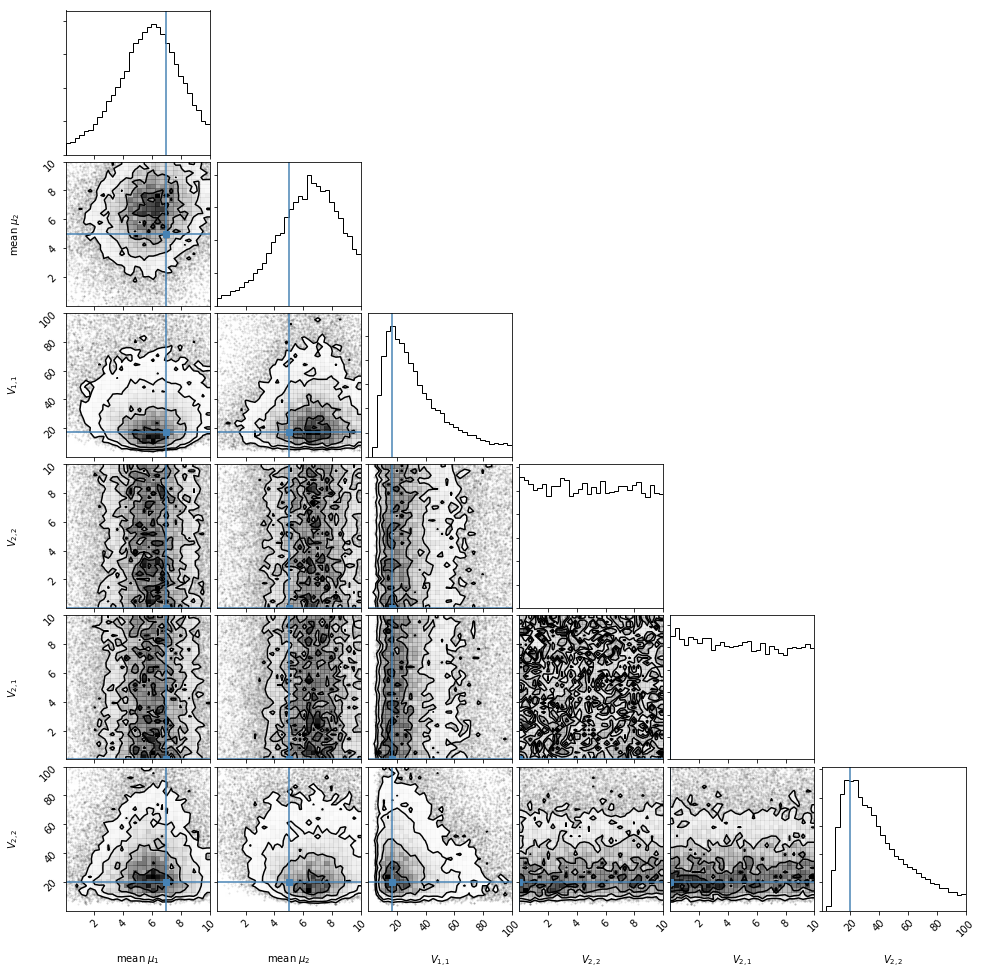

In [141]:
fig = corner(correct_mcmc_samples_thin, bins=32, 
             labels=[r'mean $\mu_1$', r'mean $\mu_2$', r'$V_{1,1}$', r'$V_{2,2}$', r'$V_{2,1}$', r'$V_{2,2}$'], 
             range=[prior_info_correct[0:2], prior_info_correct[2:4], 
                    prior_info_correct[4:6], prior_info_correct[6:8],
                    prior_info_correct[8:10], prior_info_correct[10:12]],
             truths=Truth)

Now for the pseudo-likelihood case: 
$$ ln \; p_{pseudo}({\bf s}_y^2|{\bf V}) \propto -\frac{1}{2} ({\bf s_y}^2 - {\bf V})^T(\Sigma^2)^{-1}({\bf s_y}^2 - {\bf V})$$
where we'll estimate $\Sigma^2$ from mock observations, analogous to cosmology analyses. To be conservative, we'll use the actual Truth parameter values to gerenate the mock data. 

In [238]:
var_mocks = []
for seed in range(8,1008): 
    np.random.seed(seed)
    emp_truth = np.array([mu_emp[0], mu_emp[1], cov_emp[0,0], cov_emp[0,1], cov_emp[1,0], cov_emp[1,1]])
    mock = datadraw(emp_truth, N)
    var_mocks.append(np.array([Hogg.hoggvar(mock[:,0]), Hogg.hoggvar(mock[:,1])]))
var_mocks = np.array(var_mocks)
print var_mocks.shape
print var_mocks[:5,:]

(1000, 2)
[[ 44.70001243  46.96205753]
 [  1.18252274   7.54802084]
 [  7.09805245  18.5797886 ]
 [ 21.55311661  14.33876183]
 [ 35.21041049  21.34020428]]


In [239]:
Sig = np.cov(var_mocks.T)
print Sig.shape
print Sig
invSig = np.linalg.inv(Sig)

(2, 2)
[[ 108.81177165   -9.21635179]
 [  -9.21635179  191.00577429]]


In [240]:
def ln_pseudo_likelihood(empiricalvars, pars, sigma):
    res = empiricalvars - pars[2:4]
    return (-0.5 * np.sum(np.dot(res, np.linalg.solve(sigma, res))))

def ln_pseudo_posterior(pars, empiricalvar, sigma, prior_info):
    lnp = ln_prior0(pars, prior_info)
    if not np.isfinite(lnp):
        return -np.Inf
    return lnp + ln_pseudo_likelihood(empiricalvar, pars, sigma)

In [241]:
prior_info_pseudo = np.array([0., 10., 0., 10., 0., 100., 0., 100.])
stepsizes_pseudo = np.array([4., 4., 4., 4.])
Truth_pseudo = np.array([7., 5., 17., 20.])
pars0 = Truth_pseudo.copy()
pseudo_mcmc_samples = mcmc(pars0, ln_pseudo_posterior, Tbig, 
                           (np.array([cov_emp[0,0], cov_emp[1,1]]), Sig, prior_info_pseudo, ), stepsizes=stepsizes_pseudo)

In [242]:
accept = pseudo_mcmc_samples[1:] != pseudo_mcmc_samples[:-1]
print "acceptance ratio", np.mean(accept)

acceptance ratio 0.377957111277


In [243]:
pseudo_mcmc_samples_thin = pseudo_mcmc_samples[::thinfactor] # thin
print pseudo_mcmc_samples_thin.shape

(32768, 4)


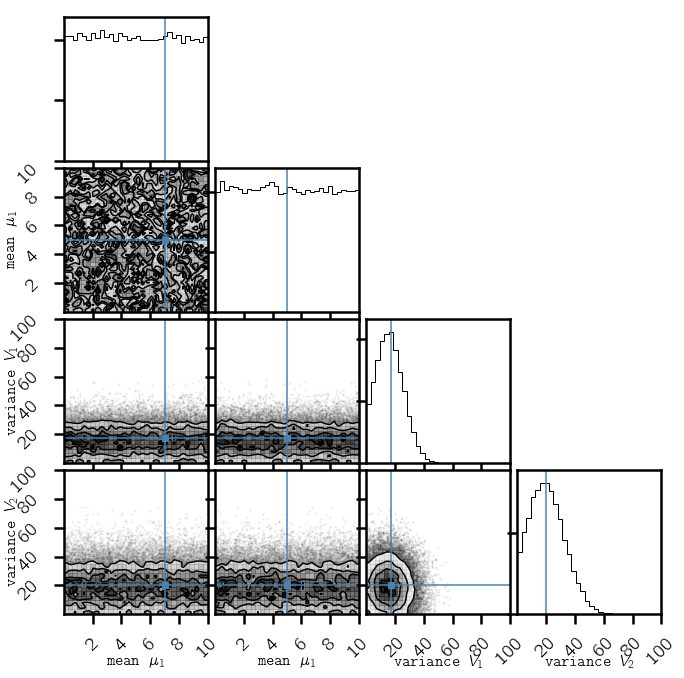

In [244]:
fig = corner(pseudo_mcmc_samples_thin, bins=32, labels=[r'mean $\mu_1$', r'mean $\mu_1$', r'variance $V_1$', r'variance $V_2$'], 
             range=[prior_info_pseudo[0:2], prior_info_pseudo[2:4], prior_info_pseudo[4:6], prior_info_pseudo[6:8]], 
             truths=Truth_pseudo)

(0.0, 100.0)

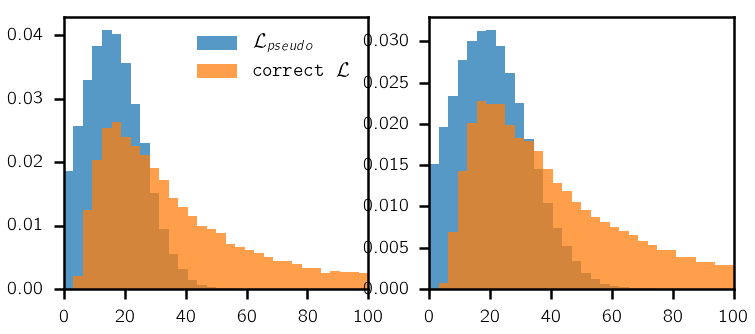

In [245]:
v2s = pseudo_mcmc_samples_thin[:,-1]
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121)
ax.hist(pseudo_mcmc_samples[:,-2], bins=32, range=[0.,100.], alpha=0.75, normed=True, label='$\mathcal{L}_{pseudo}$')
ax.hist(correct_mcmc_samples[:,2], bins=32, range=[0., 100.], alpha=0.75, normed=True, label='correct $\mathcal{L}$')
ax.legend(loc='upper right', prop={'size': 20})
ax.set_xlim([0., 100.])
ax = fig.add_subplot(122)
ax.hist(pseudo_mcmc_samples[:,-1], bins=32, range=[0.,100.], alpha=0.75, normed=True)
ax.hist(correct_mcmc_samples[:,-1], bins=32, range=[0., 100.], alpha=0.75, normed=True)
ax.set_xlim([0., 100.])

Now lets see how well ICA method does

In [246]:
ica = FastICA(n_components=2, algorithm='deflation')
ica.fit_transform(var_mocks)  # Reconstruct signals
varp_mocks = ica.transform(var_mocks)

(-0.1, 0.1)

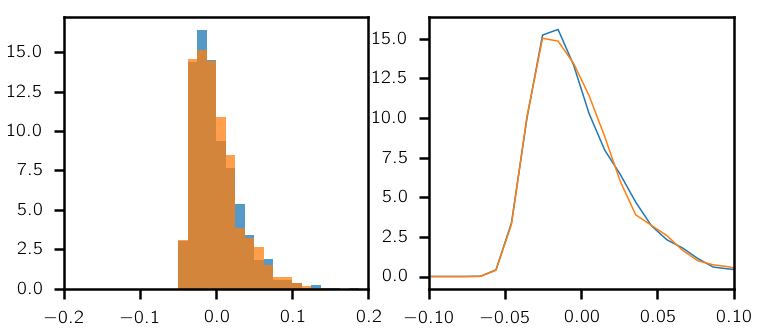

In [247]:
pV0, edges = np.histogram(varp_mocks[:,0], normed=True)
pV0_arr = UT.bar_plot(edges, pV0)

pV1, edges = np.histogram(varp_mocks[:,1], normed=True)
pV1_arr = UT.bar_plot(edges, pV1)

prettyplot()
fig = plt.figure(figsize=(12,5))
sub = fig.add_subplot(121)
sub.hist(varp_mocks[:,0], bins=32, range=[-0.2, 0.2], normed=True, alpha=0.75)
sub.hist(varp_mocks[:,1], bins=32, range=[-0.2, 0.2], normed=True, alpha=0.75)
sub.set_xlim([-0.2, 0.2])

sub = fig.add_subplot(122)
K0 = gkde(varp_mocks[:,0])
K1 = gkde(varp_mocks[:,1])
x = np.linspace(-0.25, 0.25, 50)

sub.plot(x, K0.evaluate(x))
sub.plot(x, K1.evaluate(x))
sub.set_xlim([-0.1, 0.1])

In [248]:
def ln_ICA_likelihood(empiricalvars, pars):
    varp = ica.transform(pars[2:4].reshape(1,-1))
    return np.log(K0.evaluate(varp[0][0]) * K1.evaluate(varp[0][1]))

def ln_ICA_posterior(pars, empiricalvar, prior_info):
    lnp = ln_prior0(pars, prior_info)
    if not np.isfinite(lnp):
        return -np.Inf
    return lnp + ln_ICA_likelihood(empiricalvar, pars)

In [249]:
ica_mcmc_samples = mcmc(pars0, ln_ICA_posterior, Tbig, (np.array([cov_emp[0,0], cov_emp[1,1]]), prior_info_pseudo, ), stepsizes=stepsizes_pseudo)

In [250]:
accept = ica_mcmc_samples[1:] != ica_mcmc_samples[:-1]
print "acceptance ratio", np.mean(accept)

acceptance ratio 0.364731530631


In [251]:
ica_mcmc_samples_thin = ica_mcmc_samples[::thinfactor] # thin
print ica_mcmc_samples_thin.shape

(32768, 4)


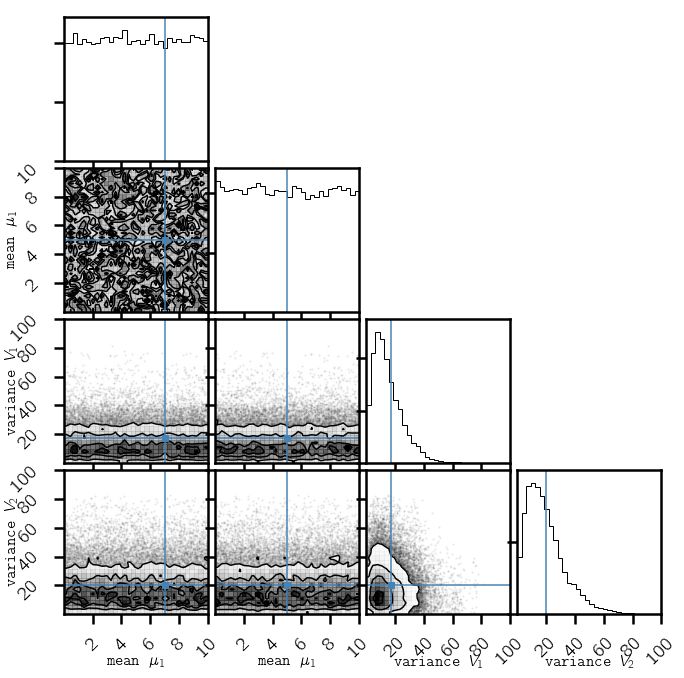

In [252]:
fig = corner(ica_mcmc_samples_thin, bins=32, labels=[r'mean $\mu_1$', r'mean $\mu_1$', r'variance $V_1$', r'variance $V_2$'], 
             range=[prior_info_pseudo[0:2], prior_info_pseudo[2:4], prior_info_pseudo[4:6], prior_info_pseudo[6:8]], 
             truths=Truth_pseudo)

PCA is not really interesting but just as a sanity check 

In [253]:
# For comparison, compute PCA
pca = PCA(n_components=2)
pca.fit_transform(var_mocks)
var_pca_mocks = pca.transform(var_mocks)

In [256]:
varvar_pca_mocks = np.array([Hogg.hoggvar(var_pca_mocks[:,0]), Hogg.hoggvar(var_pca_mocks[:,1])])
muvar_pca_mocks = np.array([np.mean(var_pca_mocks[:,0]), np.mean(var_pca_mocks[:,1])])
pca_mock_stats = np.array([muvar_pca_mocks[0], muvar_pca_mocks[1], varvar_pca_mocks[0], varvar_pca_mocks[1]])

In [263]:
def ln_PCA_likelihood(mock_pca_stats, pars):
    muvar = mock_pca_stats[0:2]
    varvar = mock_pca_stats[2:4]
    varp = pca.transform(pars[2:4].reshape(1,-1))
    return -0.5 * (varp[0][0] - muvar[0])**2/varvar[0] - 0.5 * (varp[0][1] - muvar[1])**2/varvar[1]

def ln_PCA_posterior(pars, mock_pca_stats, prior_info):
    lnp = ln_prior0(pars, prior_info)
    if not np.isfinite(lnp):
        return -np.Inf
    return lnp + ln_PCA_likelihood(mock_pca_stats, pars)

In [264]:
pca_mcmc_samples = mcmc(pars0, ln_PCA_posterior, Tbig, 
                        (pca_mock_stats, prior_info_pseudo, ), stepsizes=stepsizes_pseudo)

In [265]:
accept = pca_mcmc_samples[1:] != pca_mcmc_samples[:-1]
print "acceptance ratio", np.mean(accept)

acceptance ratio 0.377093080698


In [266]:
pca_mcmc_samples_thin = pca_mcmc_samples[::thinfactor]
print pca_mcmc_samples_thin.shape

(32768, 4)


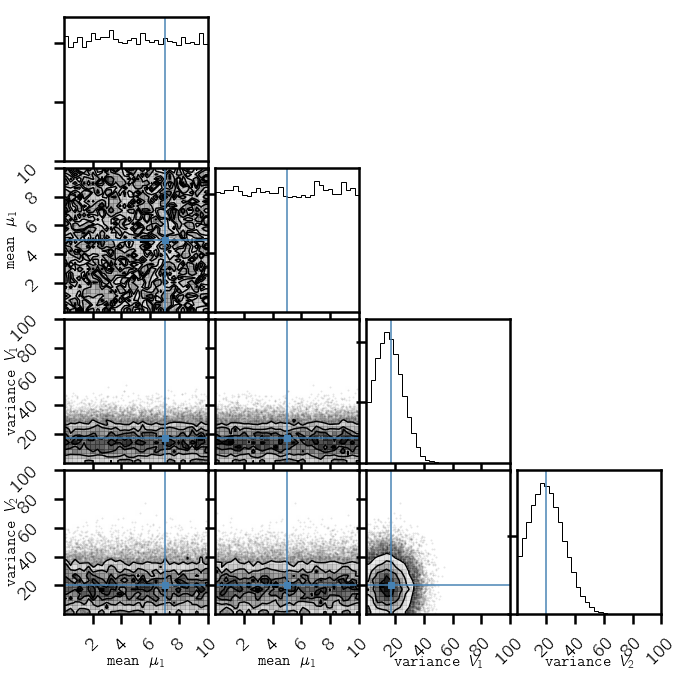

In [267]:
fig = corner(pca_mcmc_samples_thin, bins=32, labels=[r'mean $\mu_1$', r'mean $\mu_1$', r'variance $V_1$', r'variance $V_2$'], 
             range=[prior_info_pseudo[0:2], prior_info_pseudo[2:4], prior_info_pseudo[4:6], prior_info_pseudo[6:8]], 
             truths=Truth_pseudo)

(0.0, 100.0)

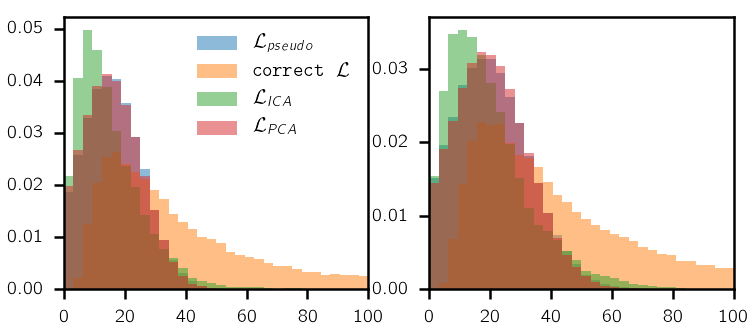

In [268]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121)
ax.hist(pseudo_mcmc_samples[:,-2], bins=32, range=[0.,100.], alpha=0.5, normed=True, label='$\mathcal{L}_{pseudo}$')
ax.hist(correct_mcmc_samples[:,2], bins=32, range=[0., 100.], alpha=0.5, normed=True, label='correct $\mathcal{L}$')
ax.hist(ica_mcmc_samples[:,-2], bins=32, range=[0., 100.], alpha=0.5, normed=True, label='$\mathcal{L}_{ICA}$')
ax.hist(pca_mcmc_samples[:,-2], bins=32, range=[0., 100.], alpha=0.5, normed=True, label='$\mathcal{L}_{PCA}$')
ax.legend(loc='upper right', prop={'size': 20})
ax.set_xlim([0., 100.])
ax = fig.add_subplot(122)
ax.hist(pseudo_mcmc_samples[:,-1], bins=32, range=[0.,100.], alpha=0.5, normed=True)
ax.hist(correct_mcmc_samples[:,-1], bins=32, range=[0.,100.], alpha=0.5, normed=True)
ax.hist(ica_mcmc_samples[:,-1], bins=32, range=[0., 100.], alpha=0.5, normed=True)
ax.hist(pca_mcmc_samples[:,-1], bins=32, range=[0., 100.], alpha=0.5, normed=True)
ax.set_xlim([0., 100.])

What if you just use the Gaussian KDE estimate of $p({\bf s}^2_y)$? 

In [288]:
# lets whiten the variance mocks
L = np.linalg.cholesky(invSig)
mu_var_mocks = np.mean(var_mocks, axis=0)
var_mocks_w = (np.dot(L.T, (var_mocks - mu_var_mocks).T)).T

In [289]:
K_2D = gkde(np.vstack([var_mocks_w[:,0], var_mocks_w[:,1]]))

In [290]:
print var_mocks_w[:,0].min()
print var_mocks_w[:,0].max()
print var_mocks_w[:,1].min()
print var_mocks_w[:,1].max()

-1.48050194535
5.78648875605
-1.35276480644
8.50469379334


In [299]:
def ln_sy_likelihood(empiricalvars, pars):
    varp = np.dot(L.T, pars[2:4]-mu_var_mocks)
    return np.log(K_2D.evaluate(varp))

def ln_sy_posterior(pars, empiricalvar, prior_info):
    lnp = ln_prior0(pars, prior_info)
    if not np.isfinite(lnp):
        return -np.Inf
    return lnp + ln_sy_likelihood(empiricalvar, pars)

In [300]:
sy_mcmc_samples = mcmc(pars0, ln_sy_posterior, Tbig, 
                        (pca_mock_stats, prior_info_pseudo, ), stepsizes=stepsizes_pseudo)

In [301]:
accept = sy_mcmc_samples[1:] != sy_mcmc_samples[:-1]
print "acceptance ratio", np.mean(accept)

acceptance ratio 0.366266949209


In [302]:
sy_mcmc_samples_thin = sy_mcmc_samples[::thinfactor]
print sy_mcmc_samples_thin.shape

(32768, 4)


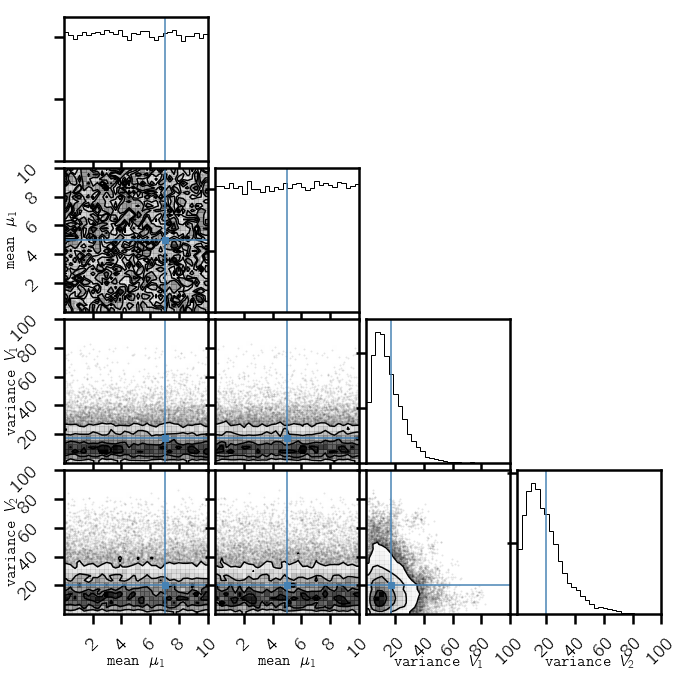

In [303]:
fig = corner(sy_mcmc_samples_thin, bins=32, labels=[r'mean $\mu_1$', r'mean $\mu_1$', r'variance $V_1$', r'variance $V_2$'], 
             range=[prior_info_pseudo[0:2], prior_info_pseudo[2:4], prior_info_pseudo[4:6], prior_info_pseudo[6:8]], 
             truths=Truth_pseudo)

(0.0, 100.0)

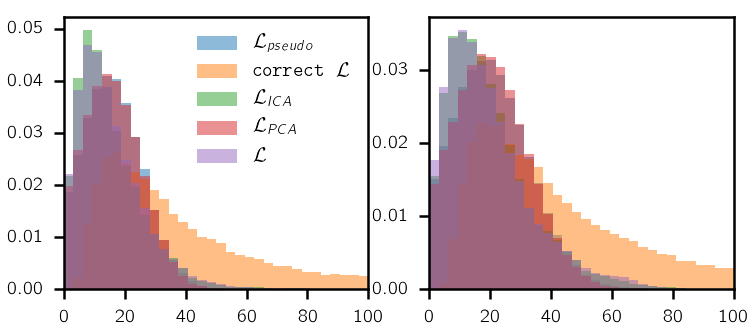

In [305]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121)
ax.hist(pseudo_mcmc_samples[:,-2], bins=32, range=[0.,100.], alpha=0.5, normed=True, label='$\mathcal{L}_{pseudo}$')
ax.hist(correct_mcmc_samples[:,2], bins=32, range=[0., 100.], alpha=0.5, normed=True, label='correct $\mathcal{L}$')
ax.hist(ica_mcmc_samples[:,-2], bins=32, range=[0., 100.], alpha=0.5, normed=True, label='$\mathcal{L}_{ICA}$')
ax.hist(pca_mcmc_samples[:,-2], bins=32, range=[0., 100.], alpha=0.5, normed=True, label='$\mathcal{L}_{PCA}$')
ax.hist(sy_mcmc_samples[:,-2], bins=32, range=[0., 100.], alpha=0.5, normed=True, label='$\mathcal{L}$')
ax.legend(loc='upper right', prop={'size': 20})
ax.set_xlim([0., 100.])
ax = fig.add_subplot(122)
ax.hist(pseudo_mcmc_samples[:,-1], bins=32, range=[0.,100.], alpha=0.5, normed=True)
ax.hist(correct_mcmc_samples[:,-1], bins=32, range=[0.,100.], alpha=0.5, normed=True)
ax.hist(ica_mcmc_samples[:,-1], bins=32, range=[0., 100.], alpha=0.5, normed=True)
ax.hist(pca_mcmc_samples[:,-1], bins=32, range=[0., 100.], alpha=0.5, normed=True)
ax.hist(sy_mcmc_samples[:,-1], bins=32, range=[0., 100.], alpha=0.5, normed=True)
ax.set_xlim([0., 100.])